In [4]:
# %tensorflow_version 2.x # used Jupyter Notebook with TensorFlow 2.2.0-rc1
import tensorflow as tf
print(tf.__version__)

import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline

2.2.0-rc1


In [5]:
plt.rcParams["figure.figsize"] = (12, 5)

%tensorflow_version 2.x - специальная магия Colab, которая переключает версию TensorFlow с 1.х (всё ещё подключенной по умолчанию) в 2.х. Это не заработает в локально выполняемом Jupyter Notebook.


Если вы в Colab, не забудьте подключить GPU в меню: Runtime -> Change runtime type -> Hardware accelerator: GPU.

# Введение в TensorFlow 2.x

## Tensors

Все объекты в TensorFlow являются тензором (многомерной матрицей). Все операции принимают тензор (или несколько) и возвращают тензор.

Самые распространённые типы тензоров - константный и переменный. Как ясно из названия, значения константного тензора менять нельзя.


Вот [константный](https://www.tensorflow.org/api_docs/python/tf/constant) тензор:

In [3]:
x = tf.constant([[5, 2], [1, 3]])

x

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5, 2],
       [1, 3]])>

Его значения можно получить в формате numpy массива, вызвав метод `.numpy()`:

In [4]:
x.numpy()

array([[5, 2],
       [1, 3]])

Также, как и у массива numpy, у тензора есть тип `dtype` и размерность `shape`:

In [5]:
print('dtype:', x.dtype)
print('shape:', x.shape)

dtype: <dtype: 'int32'>
shape: (2, 2)


Распространённый способ делать константные тензоры это `tf.ones` и `tf.zeros` (такие же, как `np.ones` and `np.zeros`):

In [6]:
print(tf.ones(shape=(2, 2)))
print(tf.zeros(shape=(2, 2)))

tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[0. 0.]
 [0. 0.]], shape=(2, 2), dtype=float32)


## Случайные константные тензоры

 [Нормальный](https://www.tensorflow.org/api_docs/python/tf/random/normal) тензор: 

In [7]:
tf.random.normal(shape=(1, 10), mean=0., stddev=1.)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-0.70110905,  0.10254255,  0.7193365 , -2.7121475 ,  2.0292735 ,
        -1.3571799 , -1.3971539 , -0.12314343,  0.35483792,  1.1245372 ]],
      dtype=float32)>

Тензор, заполненный [равномерно](https://www.tensorflow.org/api_docs/python/tf/random/uniform) распределёнными целыми числами:

In [8]:
tf.random.uniform(shape=(2, 2), minval=0, maxval=10, dtype='int32')

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[6, 8],
       [9, 2]])>

## Переменные

[Переменные](https://www.tensorflow.org/guide/variable) это тензоры, которые могут изменяться с помощью специальных операций. Веса нейронных сетей и других моделей будут переменными тензорами. 

При создании переменной ей должно быть присвоено какое-нибудь начальное значение:

In [9]:
initial_value = tf.random.normal(shape=(2, 2))
a = tf.Variable(initial_value)

a

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.4532555 , -0.09650838],
       [ 0.2511088 ,  0.05731175]], dtype=float32)>

Базовый способ изменять значение переменных -- использовать операции присваивания `.assign(value)`, прибавления `.assign_add(increment)` или вычитания `.assign_sub(decrement)`:

In [10]:
new_value = tf.random.normal(shape=(2, 2))
a.assign(new_value)

# check if it's worked
for i in range(2):
    for j in range(2):
        assert a[i, j] == new_value[i, j]

In [11]:
added_value = tf.random.normal(shape=(2, 2))
a.assign_add(added_value)

for i in range(2):
    for j in range(2):
        assert a[i, j] == new_value[i, j] + added_value[i, j]

## Математические расчёты в TensorFlow

Любой рассчёт в TensorFlow - это вычислительный граф, в узлах которого находятся тензоры или операции над ними. 

Чтобы выполнить расчёт, нужно описать граф вычислений, заполнить его начальными значениями и запустить выполнение.

К счастью, в TensorFlow 2.x (в отличие от предыдущей версии) бОльшая часть этого процесса выполняется автоматически, и зачастую его можно использовать точно так же, как Numpy, делая объявление-присваивание-вычисление в один проход. В большинстве случаев работает простая замена `np.` на `tf.`. 

Основная разница между Numpy и TensorFlow для расчётных задач в том, что код TensorFlow при этом может сразу работать на GPU или TPU.

In [12]:
a = tf.random.normal(shape=(2, 2))
b = tf.random.normal(shape=(2, 2))

c = a + b
d = tf.square(c)
e = tf.exp(d)

## Вычисление градиента с `GradientTape`

Другое большое отличие от Numpy: вы можете получить градиент любого выражения в момент его выполнения.

Для этого конкретное выполнение выражения нужно "записать на ленту" с помощью [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape). Также необходимо указать, какой тензор вас интересует, используя `.watch()`, и после выполнения ленты, вы сможете узнать, как изменения в этом тензоре влияли на любой другой узел, участвовавший в операции (то есть получить градиент любого узла относительно интересующего):

In [13]:
a = tf.random.normal(shape=(2, 2))
b = tf.random.normal(shape=(2, 2))

with tf.GradientTape() as tape:
    tape.watch(a)  # Start recording the history of operations applied to `a`
    c = tf.sqrt(tf.square(a) + tf.square(b))  # Do some math using `a`

    # What's the gradient of `c` with respect to `a`?
    dc_da = tape.gradient(c, a)
    print(dc_da)

tf.Tensor(
[[ 0.36976627 -0.9001818 ]
 [ 0.99118686  0.6247254 ]], shape=(2, 2), dtype=float32)


Вам нужно использовать `watch` только для константных тензоров. Для всех переменных тензоров `watch` включен по умолчанию:

In [14]:
a = tf.Variable(a) # after we made it Variable instead constant

with tf.GradientTape() as tape:
    # we need no watch(a)
    c = tf.sqrt(tf.square(a) + tf.square(b))

    dc_da = tape.gradient(c, a)
    print(dc_da)

tf.Tensor(
[[ 0.36976627 -0.9001818 ]
 [ 0.99118686  0.6247254 ]], shape=(2, 2), dtype=float32)


Обратите внимание, что вы можете вычислять производные высших порядков, используя вложенные ленты:

In [15]:
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as tape:
        c = tf.sqrt(tf.square(a) + tf.square(b))
        dc_da = tape.gradient(c, a)

    d2c_da2 = outer_tape.gradient(dc_da, a) # second order gradient
    print(d2c_da2)

tf.Tensor(
[[1.8257421  0.13953328]
 [0.00690788 0.4020228 ]], shape=(2, 2), dtype=float32)


## Пример от начала до конца: линейная регрессия

Итак, пока что TensorFlow можно воспринимать как замену Numpy с поддержкой параллельных вычислений и автоматическим дифференцированием.

Рассмотрим в качестве базового примера его использования обычную линейную регрессию.

Для честности мы будем использовать только базовые операции.

In [16]:
input_dim = 1 # shape of input sample
output_dim = 1 # shape of prediction
learning_rate = 0.01

# This is our weight matrix
w = tf.Variable(tf.random.uniform(shape=(input_dim, output_dim)))
# This is our bias vector
b = tf.Variable(tf.zeros(shape=(output_dim,)))

print(w)
print(b)

<tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.06705785]], dtype=float32)>
<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>


In [17]:
def compute_predictions(features):
    return tf.matmul(features, w) + b # matmul is for matrix multiplication


def compute_loss(labels, predictions):
    return tf.reduce_mean(tf.square(labels - predictions)) # tf.reduce_mean is equivalent to np.mean


def train_on_batch(x, y):
    with tf.GradientTape() as tape:
        predictions = compute_predictions(x)
        loss = compute_loss(y, predictions) 
        # Note that `tape.gradient` works with a list argument as well.
        dloss_dw, dloss_db = tape.gradient(loss, [w, b]) # gradient of loss with respect to weights and biases

    w.assign_sub(learning_rate * dloss_dw) # apply weights correction
    b.assign_sub(learning_rate * dloss_db) # apply biases correction

    return loss # just for print

Создадим простой датасет

In [18]:
mean = [-1, 1] 
cov = [[1, -0.8], 
       [-0.8, 1]] 
size = 10000
sample = np.random.multivariate_normal(mean, cov, size=size).astype(np.float32)

X, y_true = sample[:, 0].reshape((size, 1)), sample[:, 1].reshape((size, 1))

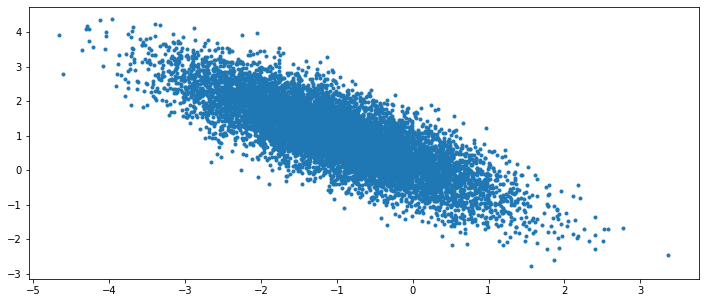

In [19]:
plt.plot(X, y_true, '.')

Разделим датасет на пакеты и обучим модель, многократно выполнив `train_on_batch` на каждом пакете:

In [20]:
# Create a tf.data.Dataset object for easy batched iteration
dataset = tf.data.Dataset.from_tensor_slices((X, y_true))
dataset = dataset.shuffle(buffer_size=size).batch(1024)

for epoch in range(10):
    for step, (x, y) in enumerate(dataset):
        loss = train_on_batch(x, y)

    print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

Epoch 0: last batch loss = 1.0473
Epoch 1: last batch loss = 0.5929
Epoch 2: last batch loss = 0.4359
Epoch 3: last batch loss = 0.3665
Epoch 4: last batch loss = 0.3750
Epoch 5: last batch loss = 0.3624
Epoch 6: last batch loss = 0.3407
Epoch 7: last batch loss = 0.3638
Epoch 8: last batch loss = 0.3788
Epoch 9: last batch loss = 0.3791


Результат:

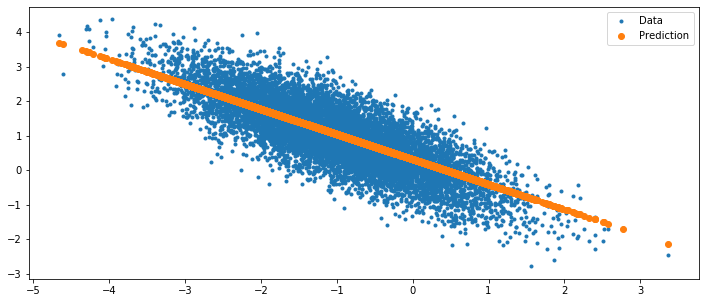

In [21]:
predictions = compute_predictions(X)

plt.plot(X, y_true, '.', label='Data')
plt.plot(X, predictions, 'o', label='Prediction')
plt.legend()

## Ускорение с помощью `tf.function`

Насколько быстрым является такое обучение?

In [22]:
%%timeit

for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, y)

21.9 ms ± 511 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Мы можем значительно ускорить вычисления, скомпилировав функцию в статический граф. В TensorFlow 2.х мы можем оформить почти любую функцию декоратором [tf.function](https://www.tensorflow.org/guide/function), чтобы получить её ускоренную статическую версию:


In [23]:
@tf.function
def train_on_batch(x, y): # no changes in the code of the function
    with tf.GradientTape() as tape:
        predictions = compute_predictions(x)
        loss = compute_loss(y, predictions) 
        # Note that `tape.gradient` works with a list argument as well.
        dloss_dw, dloss_db = tape.gradient(loss, [w, b]) # gradient of loss with respect weights and biases

    w.assign_sub(learning_rate * dloss_dw) # apply weights correction
    b.assign_sub(learning_rate * dloss_db) # apply biases correction

    return loss # just for print

Попробуем ещё раз:

In [24]:
%%timeit

for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, y)

14.6 ms ± 253 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Обычно можно увидеть до 40% ускорения для этой тривиально простой модели; более сложные модели выигрывают больше от компиляции в статический граф.

Общий подход следующий: динамическое выполнение графа ([eager execution](https://www.tensorflow.org/guide/eager)) прекрасно подходит для экспериментов, отладки и других ситуаций, когда удобно обычное построчное вычисление в python-стиле. Но когда приходит время стабилизировать код и масштабироваться, компиляция всего, что можно, в статические графы, даёт значительное преимущество.

## Пример посложнее: нейросеть

Поставим задачу классификации:

In [25]:
# Prepare a dataset.
num_samples = 10000

negative_samples = np.random.multivariate_normal(mean=[0, 3], cov=[[1.2, 0.7], [0.7, 1.2]], size=num_samples)
positive_samples = np.random.multivariate_normal(mean=[3, 0], cov=[[1.5, -0.2], [-0.2, 1.5]], size=num_samples)

features = np.vstack((negative_samples, positive_samples)).astype(np.float32)
labels = np.vstack((np.zeros((num_samples, 1), dtype='float32'),
                    np.ones((num_samples, 1), dtype='float32')))

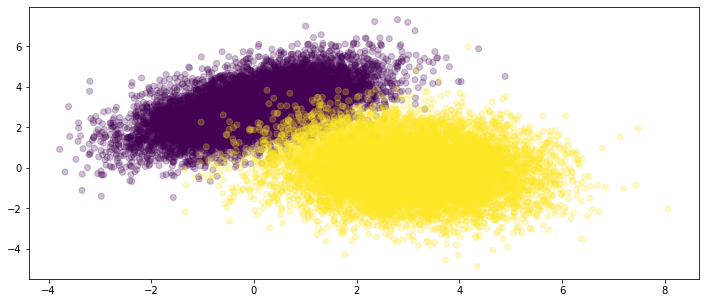

In [26]:
plt.scatter(features[:, 0], features[:, 1], c=labels[:, 0], alpha=0.25)

Основной принцип создания нейросети не отличается от создания линейной регрессии, однако из-за большого количества сущностей внутри модели, управлять ими в "наивном" стиле сложнее.

Попробуем внести некоторую оптимизацию: cохраним веса модели в словари, чтобы можно было обращаться к ним по именам

In [27]:
# Network Parameters

n_hidden_1 = 32 # 1st layer number of neurons
n_hidden_2 = 16 # 2nd layer number of neurons

input_dim = features.shape[1]
output_dim = labels.shape[1] 

# Store layers weights & biases
weights = {
    'W1': tf.Variable(tf.random.normal([input_dim, n_hidden_1])),
    'W2': tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_hidden_2, output_dim]))
}

biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'out': tf.Variable(tf.random.normal([output_dim]))
}

Мы можем хранить переменные в каких-угодно python-структурах или не хранить вообще: это всё лишь ссылки на объекты TensorFlow, которые существуют независимо от того, как они называются или хранятся на уровне языка.



Создание модели - это просто описание того, как она превращает входы в выходы:

In [28]:
# Create model
def compute_mlp_predictions(x):
    # Hidden fully connected layer 
    layer_1 = tf.add(tf.matmul(x, weights['W1']), biases['b1'])
    act_1 = tf.nn.sigmoid(layer_1)

    # Hidden fully connected layer 
    layer_2 = tf.add(tf.matmul(act_1, weights['W2']), biases['b2'])
    act_2 = tf.nn.sigmoid(layer_2)

    # Output fully connected layer
    out_layer = tf.matmul(act_2, weights['out']) + biases['out']
    out_act = tf.nn.sigmoid(out_layer)

    return out_act

Зададим Log-loss целевую функцию для решения задачи классификации

In [29]:
def logloss(y, predictions, eps=1e-5):
    # log-loss is undefined for prediction == 0 or 1, so we are clipping it little bit
    predictions = tf.clip_by_value(predictions, eps, 1 - eps)

    return tf.reduce_sum(-(y * tf.math.log(predictions) + (1 - y) * tf.math.log(1 - predictions)))

In [30]:
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(buffer_size=len(features)).batch(1024)

In [31]:
from sklearn.metrics import accuracy_score

Вместо того, чтобы вручную обновлять все веса модели, доверим это оптимизатору:

In [32]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)

for epoch in range(10):
    for step, (x, y) in enumerate(dataset):
        loss = lambda: logloss(y, compute_mlp_predictions(x)) # loss should be callable
        train_op = optimizer.minimize(loss, var_list=[*weights.values(), *biases.values()])

    y_predicted = np.where(compute_mlp_predictions(x) > 0.5, 1, 0)
    accuracy = accuracy_score(y, y_predicted)
    print('Epoch %d: last batch loss = %.4f, accuracy = %.3f' % (epoch, loss(), accuracy))

Epoch 0: last batch loss = 35.4222, accuracy = 0.987
Epoch 1: last batch loss = 24.3695, accuracy = 0.987
Epoch 2: last batch loss = 20.0829, accuracy = 0.991
Epoch 3: last batch loss = 23.0084, accuracy = 0.985
Epoch 4: last batch loss = 21.2605, accuracy = 0.985
Epoch 5: last batch loss = 30.8743, accuracy = 0.976
Epoch 6: last batch loss = 25.9887, accuracy = 0.989
Epoch 7: last batch loss = 17.8037, accuracy = 0.991
Epoch 8: last batch loss = 34.9981, accuracy = 0.982
Epoch 9: last batch loss = 22.5454, accuracy = 0.989


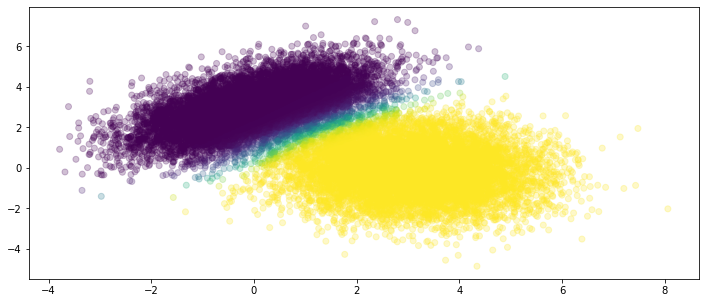

In [33]:
predictions = compute_mlp_predictions(features)

plt.scatter(features[:, 0], features[:, 1], c=predictions[:, 0], alpha=0.25)

## Задачи Tensorflow:
1. Добавьте ещё один слой нейросети
2. Добавьте L1 регуляризацию в модель, проверьте её эффект
3. Сделайте разделение данных на train и test, нарисуйте кривые обучения

In [12]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [64]:
# prepare dataset
num_samples = 10000

negative_samples = np.random.multivariate_normal(mean=[0, 3], cov=[[1.2, 0.7], [0.7, 1.2]], size=num_samples)
positive_samples = np.random.multivariate_normal(mean=[3, 0], cov=[[1.5, -0.2], [-0.2, 1.5]], size=num_samples)

features = np.vstack((negative_samples, positive_samples)).astype(np.float32)
labels = np.vstack((np.zeros((num_samples, 1), dtype='float32'),
                    np.ones((num_samples, 1), dtype='float32')))

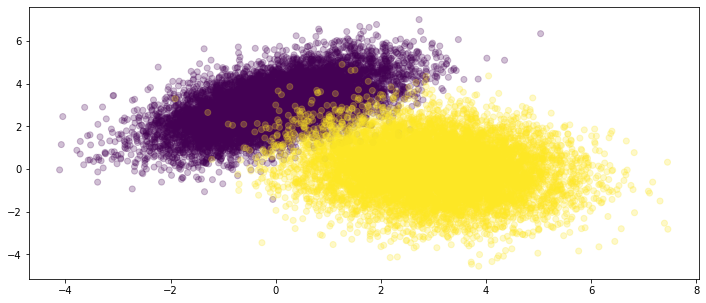

In [65]:
plt.scatter(features[:, 0], features[:, 1], c=labels[:, 0], alpha=0.25)

In [66]:
# split dataset
full_size = len(features)
train_size = int(0.7 * full_size)
val_size = int(0.15 * full_size)
test_size = int(0.15 * full_size)

dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(buffer_size=len(features)).batch(1024)

train_dataset = dataset.take(train_size)
validation_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size).take(test_size)

In [67]:
# I'm not sure that I can add 'L1 regularization', 'batch normalization' and other staff manually to the native TensorFlow.
# All articles about TF2+ and documentation which I found describe that with Keras. That's why I use Keras.

# settings
input_dim = features.shape[1]
output_dim = labels.shape[1] 
hidden_neurons = 16
l1_factor = 0.01

# init model
model = Sequential()

model.add(Dense(
    units=hidden_neurons,
    input_shape=(input_dim,),
    activation='relu', # or activation=tf.nn.relu
    kernel_regularizer=tf.keras.regularizers.l1(l1_factor))) # hidden layer 1

model.add(Dense(
    hidden_neurons,
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l1(l1_factor))) # hidden layer 2

model.add(Dense(
    hidden_neurons,
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l1(l1_factor))) # hidden layer 3

model.add(Dense(
    output_dim,
    activation='sigmoid'))

# compile model
model.compile(
    optimizer=optimizer,
    loss=logloss,
    metrics=['accuracy'])

In [68]:
# train model

# got issue on my Jupyter Notebook (UnboundLocalError: local variable 'logs' referenced before assignment), TF 2.2.0-rc1
# https://github.com/tensorflow/tensorflow/issues/38064
# history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset, verbose=1)

history = model.fit(x=features, y=labels, validation_split=0.25, batch_size=1024, shuffle=True, epochs=10, verbose=1)

Epoch 1/10
15/15 [==============================] - 0s 8ms/step - loss: 817.9993 - accuracy: 0.7131 - val_loss: 501.0353 - val_accuracy: 0.9938
Epoch 2/10
15/15 [==============================] - 0s 3ms/step - loss: 330.1553 - accuracy: 0.9091 - val_loss: 640.7635 - val_accuracy: 0.9908
Epoch 3/10
15/15 [==============================] - 0s 3ms/step - loss: 199.2163 - accuracy: 0.9650 - val_loss: 353.3173 - val_accuracy: 0.9764
Epoch 4/10
15/15 [==============================] - 0s 3ms/step - loss: 232.3725 - accuracy: 0.9767 - val_loss: 212.3415 - val_accuracy: 0.9848
Epoch 5/10
15/15 [==============================] - 0s 3ms/step - loss: 221.6707 - accuracy: 0.9599 - val_loss: 338.7207 - val_accuracy: 0.9766
Epoch 6/10
15/15 [==============================] - 0s 3ms/step - loss: 168.3358 - accuracy: 0.9765 - val_loss: 135.9937 - val_accuracy: 0.9938
Epoch 7/10
15/15 [==============================] - 0s 3ms/step - loss: 222.7734 - accuracy: 0.9453 - val_loss: 278.0480 - val_accuracy:

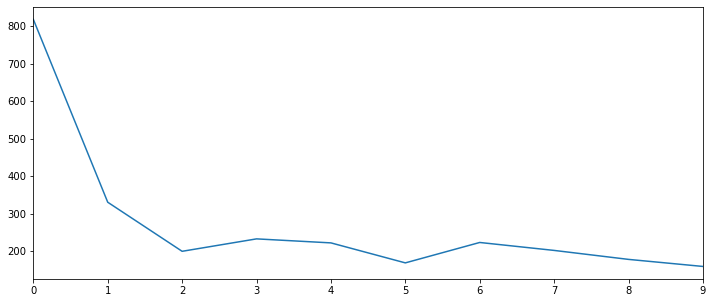

In [69]:
pd.DataFrame(history.history)['loss'].plot()

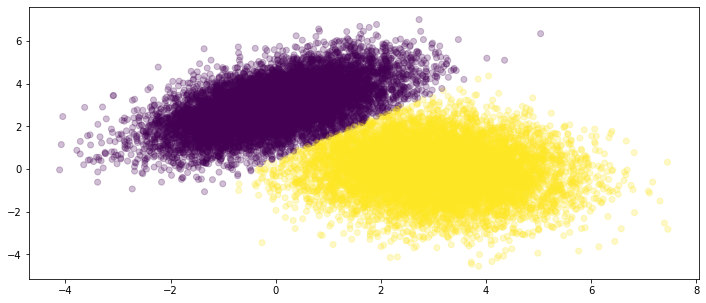

In [70]:
predictions = model.predict(features)

plt.scatter(features[:, 0], features[:, 1], c=predictions[:, 0], alpha=0.25)

## Пример Keras

Сделаем такую же модель с помощью Keras, as simple as that:

In [42]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

Keras [поддерживает](https://keras.io/models/about-keras-models/) два основных типа моделей: последовательные (Sequential) и полные (Model). 
В последовательных моделях может быть только один вход и один выход. В полных моделях может быть произвольное число входов и выходов.

In [43]:
model = Sequential()

Последовательные модели задаются простым добавлением слоёв. Первый добавленный слой должен содержать информацию о размерности входного слоя. Последний добавленный слой автоматически становится выходом модели.

In [44]:
# perceptron layer is called Dense in Keras
model.add(Dense(units=n_hidden_1, input_shape=(input_dim,), activation='sigmoid')) 
model.add(Dense(n_hidden_2, activation='sigmoid'))
model.add(Dense(output_dim, activation='sigmoid'))

Окончательно граф модели инициализируется в тот момент, когда задана функция и процедура оптимизации. Для этого в Keras используется команда [compile](https://keras.io/getting-started/sequential-model-guide/#compilation), в которую передаётся [loss](https://keras.io/losses/) функция и алгоритм [оптимизации](https://keras.io/optimizers/). Опционально можно передать и [метрики](https://keras.io/metrics/), которые не будут использоваться для оптимизации, но будут отображаться в процессе обучения.

In [45]:
model.compile(loss=logloss, optimizer=optimizer, metrics=['accuracy'])

Самые популярные функции можно передать просто по имени.

In [46]:
# model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=[logloss]) # using alternative loss as metric for comparison

Наконец, модель обучается в sklearn-стиле, возвращая объект history:

In [47]:
history = model.fit(dataset, epochs=10, verbose=1)

Epoch 1/10
20/20 [==============================] - 0s 2ms/step - loss: 526.9517 - accuracy: 0.8384
Epoch 2/10
20/20 [==============================] - 0s 2ms/step - loss: 65.9713 - accuracy: 0.9835
Epoch 3/10
20/20 [==============================] - 0s 2ms/step - loss: 56.8566 - accuracy: 0.9832
Epoch 4/10
20/20 [==============================] - 0s 2ms/step - loss: 53.8410 - accuracy: 0.9833
Epoch 5/10
20/20 [==============================] - 0s 2ms/step - loss: 53.0073 - accuracy: 0.9835
Epoch 6/10
20/20 [==============================] - 0s 2ms/step - loss: 52.6023 - accuracy: 0.9836
Epoch 7/10
20/20 [==============================] - 0s 2ms/step - loss: 51.7818 - accuracy: 0.9833
Epoch 8/10
20/20 [==============================] - 0s 2ms/step - loss: 51.5023 - accuracy: 0.9829
Epoch 9/10
20/20 [==============================] - 0s 2ms/step - loss: 51.0260 - accuracy: 0.9833
Epoch 10/10
20/20 [==============================] - 0s 2ms/step - loss: 50.7199 - accuracy: 0.9837


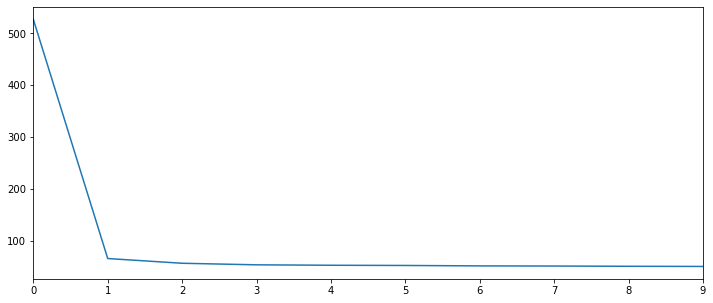

In [48]:
pd.DataFrame(history.history)['loss'].plot()

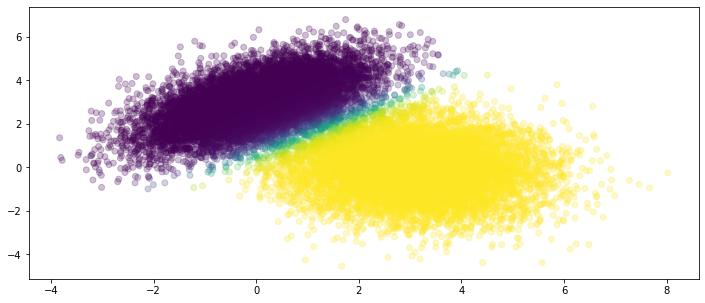

In [49]:
predictions = model.predict(features)

plt.scatter(features[:, 0], features[:, 1], c=predictions[:, 0], alpha=0.25)

## Задачи Keras
1. Модифицируйте модель Keras, так, чтобы она решала задачу регрессии. Проверьте решение на датасете из предыдущего домашнего задания.
2. Используйте кросс-валидацию sklearn, чтобы подобрать оптимальное количество нейронов и слоёв модели.

In [6]:
from sklearn import datasets

In [10]:
# Generate data
n_samples = 1000
n_outliers = 100

X, y = datasets.make_regression(n_samples=n_samples,
                                n_features=1,
                                n_informative=1,
                                noise=25,
                                coef=False,
                                random_state=1110)

X[:n_outliers] = np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = 100 * np.random.normal(size=n_outliers)

y = y + 100 * X.T[0] * np.sin(X.T[0])

X = (X - X.min()) / (X.max() - X.min())
y = (y - y.min()) / (y.max() - y.min())

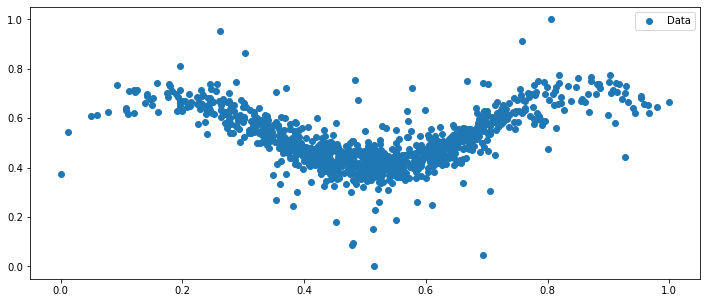

In [11]:
plt.plot(X, y, 'o', label='Data')
plt.legend()

In [23]:
# Create model
def create_model():
    model = Sequential()

    model.add(Dense(128, input_shape=(X.shape[1],), activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [50]:
model = create_model()

In [51]:
# train model
history = model.fit(x=X, y=y, validation_split=0.25, batch_size=1, epochs=20, verbose=1)

Epoch 1/20
750/750 [==============================] - 1s 1ms/step - loss: 0.0229 - mae: 0.1134 - val_loss: 0.0121 - val_mae: 0.0891
Epoch 2/20
750/750 [==============================] - 1s 1ms/step - loss: 0.0150 - mae: 0.0971 - val_loss: 0.0117 - val_mae: 0.0915
Epoch 3/20
750/750 [==============================] - 1s 1ms/step - loss: 0.0144 - mae: 0.0956 - val_loss: 0.0113 - val_mae: 0.0888
Epoch 4/20
750/750 [==============================] - 1s 1ms/step - loss: 0.0148 - mae: 0.0966 - val_loss: 0.0124 - val_mae: 0.0878
Epoch 5/20
750/750 [==============================] - 1s 1ms/step - loss: 0.0145 - mae: 0.0954 - val_loss: 0.0117 - val_mae: 0.0929
Epoch 6/20
750/750 [==============================] - 1s 1ms/step - loss: 0.0148 - mae: 0.0961 - val_loss: 0.0112 - val_mae: 0.0893
Epoch 7/20
750/750 [==============================] - 1s 1ms/step - loss: 0.0142 - mae: 0.0941 - val_loss: 0.0110 - val_mae: 0.0900
Epoch 8/20
750/750 [==============================] - 1s 1ms/step - loss: 0.

In [53]:
print('Model evaluation ', model.evaluate(X, y))

32/32 [==============================] - 0s 1ms/step - loss: 0.0062 - mae: 0.0566
Model evaluation  [0.006180965341627598, 0.05656147003173828]


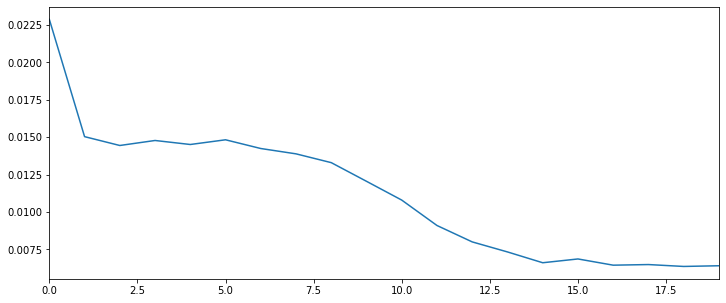

In [54]:
pd.DataFrame(history.history)['loss'].plot()

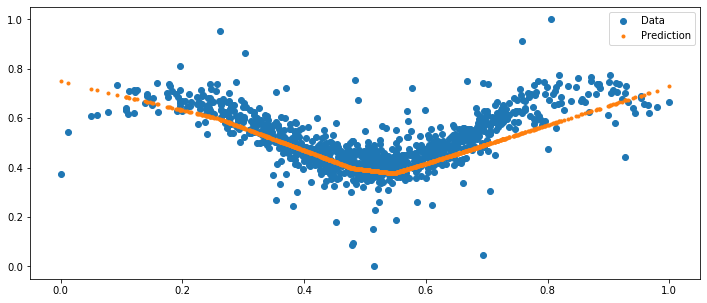

In [55]:
predictions = model.predict(X)

plt.plot(X, y, 'o', label='Data')
plt.plot(X, predictions, '.', label='Prediction')
plt.legend()

In [47]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import StratifiedKFold, KFold # some articles use these

In [56]:
# Wrap Keras model so it can be used by scikit-learn
model = KerasRegressor(build_fn=create_model, epochs=20, batch_size=1, verbose=0)

In [57]:
# Evaluate neural network using three-fold cross-validation
cross_val_score(model, X, y, cv=3)

# I don't know how to use it :)))

array([-0.01041235, -0.00295679, -0.00346605])